In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
sns.set_theme(style="whitegrid")

### Reading Dataset

In [4]:
df = pd.read_csv('Gold_Price_daily.csv')

In [5]:
df = df.drop(columns={'Adj Close', 'Volume'})
df

,Date,Close,High,Low,Open
0,NaN,GC=F,GC=F,GC=F,GC=F
1,2014-12-09,1231.5,1238.0,1202.0,1202.0
2,2014-12-10,1228.9000244140625,1234.5999755859375,1226.5999755859375,1231.199951171875
3,2014-12-11,1225.0999755859375,1231.199951171875,1216.199951171875,1226.5999755859375
4,2014-12-12,1222.0,1227.800048828125,1216.199951171875,1227.800048828125
...,...,...,...,...,...
2511,2024-12-03,2644.699951171875,2654.699951171875,2636.0,2639.0
2512,2024-12-04,2653.800048828125,2658.300048828125,2637.0,2639.199951171875
2513,2024-12-05,2626.60009765625,2655.0,2625.699951171875,2652.39990234375
2514,2024-12-06,2638.60009765625,2643.10009765625,2617.5,2620.199951171875


In [6]:
df.dropna(inplace=True)

In [8]:
df.rename(columns={'Close': 'Price'}, inplace=True)

In [9]:
df

,Date,Price,High,Low,Open
1,2014-12-09,1231.5,1238.0,1202.0,1202.0
2,2014-12-10,1228.9000244140625,1234.5999755859375,1226.5999755859375,1231.199951171875
3,2014-12-11,1225.0999755859375,1231.199951171875,1216.199951171875,1226.5999755859375
4,2014-12-12,1222.0,1227.800048828125,1216.199951171875,1227.800048828125
5,2014-12-15,1207.199951171875,1223.0999755859375,1198.4000244140625,1223.0999755859375
...,...,...,...,...,...
2511,2024-12-03,2644.699951171875,2654.699951171875,2636.0,2639.0
2512,2024-12-04,2653.800048828125,2658.300048828125,2637.0,2639.199951171875
2513,2024-12-05,2626.60009765625,2655.0,2625.699951171875,2652.39990234375
2514,2024-12-06,2638.60009765625,2643.10009765625,2617.5,2620.199951171875


In [10]:
df.info()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

<class 'pandas.core.frame.DataFrame'>
Index: 2515 entries, 1 to 2515
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2515 non-null   object
 1   Price   2515 non-null   object
 2   High    2515 non-null   object
 3   Low     2515 non-null   object
 4   Open    2515 non-null   object
dtypes: object(5)
memory usage: 117.9+ KB


### Data preparation

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# checking for duplicate
df.duplicated().sum()

0

In [14]:
# checking for missing values 
df.isnull().sum().sum()

0

**Gold price visualization**

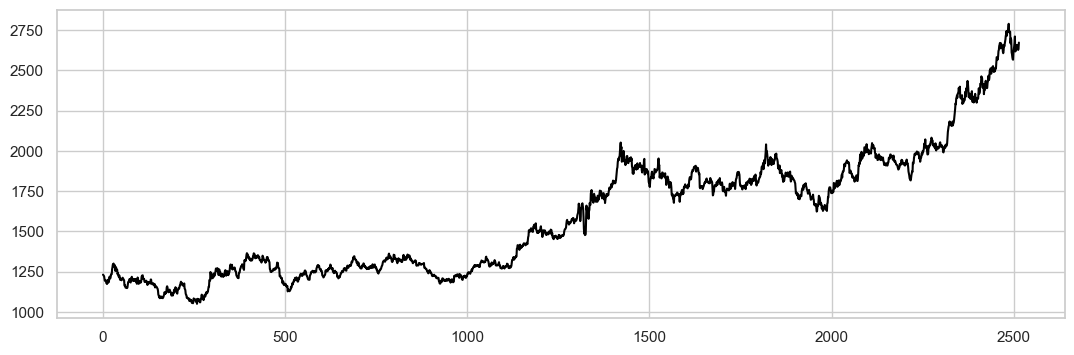

In [16]:
plt.figure(figsize=(13,4))
df['Price'].plot(color='black')
plt.show()

**setting the test size**

In [18]:
# deifne the number of days for test size
test_size = 60
test_size

60

**Gold Price Training and Test Sets Plot**

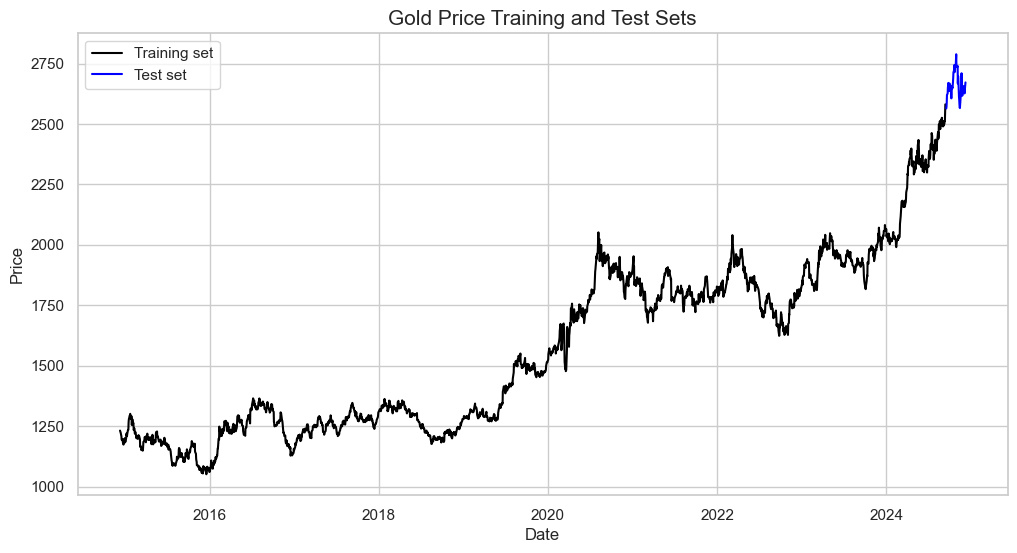

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][:-test_size], df['Price'][:-test_size], color='black')
plt.plot(df['Date'][-test_size:], df['Price'][-test_size:], color='blue')
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [21]:
# scaling the data
scaler = MinMaxScaler()
scaler.fit(df['Price'].values.reshape(-1,1))

MinMaxScaler()

In [22]:
# Setting window size 
window_size = 60 #(60 days)

**Training Set:**

In [24]:
train_data = df['Price'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [25]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

**Testing Set:**

In [27]:
test_data = df['Price'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [28]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

**Convert the data into acceptable format**

In [30]:
# convert into data format that accepting by the model
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [32]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2395, 60, 1)
y_train Shape:  (2395, 1)
X_test Shape:   (60, 60, 1)
y_test Shape:   (60, 1)


**Creating Model**

In [34]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model


**Model training**

In [36]:
import time 
t0 = time.time()

model = define_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=150,callbacks=[early_stopping], batch_size=32, validation_split=0.1, verbose=0)

print(f'How long is this take to run: {time.time() - t0}')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

How long is this take to run: 146.3064320087433


**Evaluate the model**

In [38]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1504
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [39]:
MSE = mean_squared_error(y_test, y_pred)

In [40]:
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.1493615210056305
Test MSE: 0.1493615170645674


In [41]:
# Inverse it to the normal scale 
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

In [42]:
MSE = mean_squared_error(y_test_true, y_test_pred)
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.1493615210056305
Test MSE: 451012.2759337333


**Investigating the prices predicted with actual**

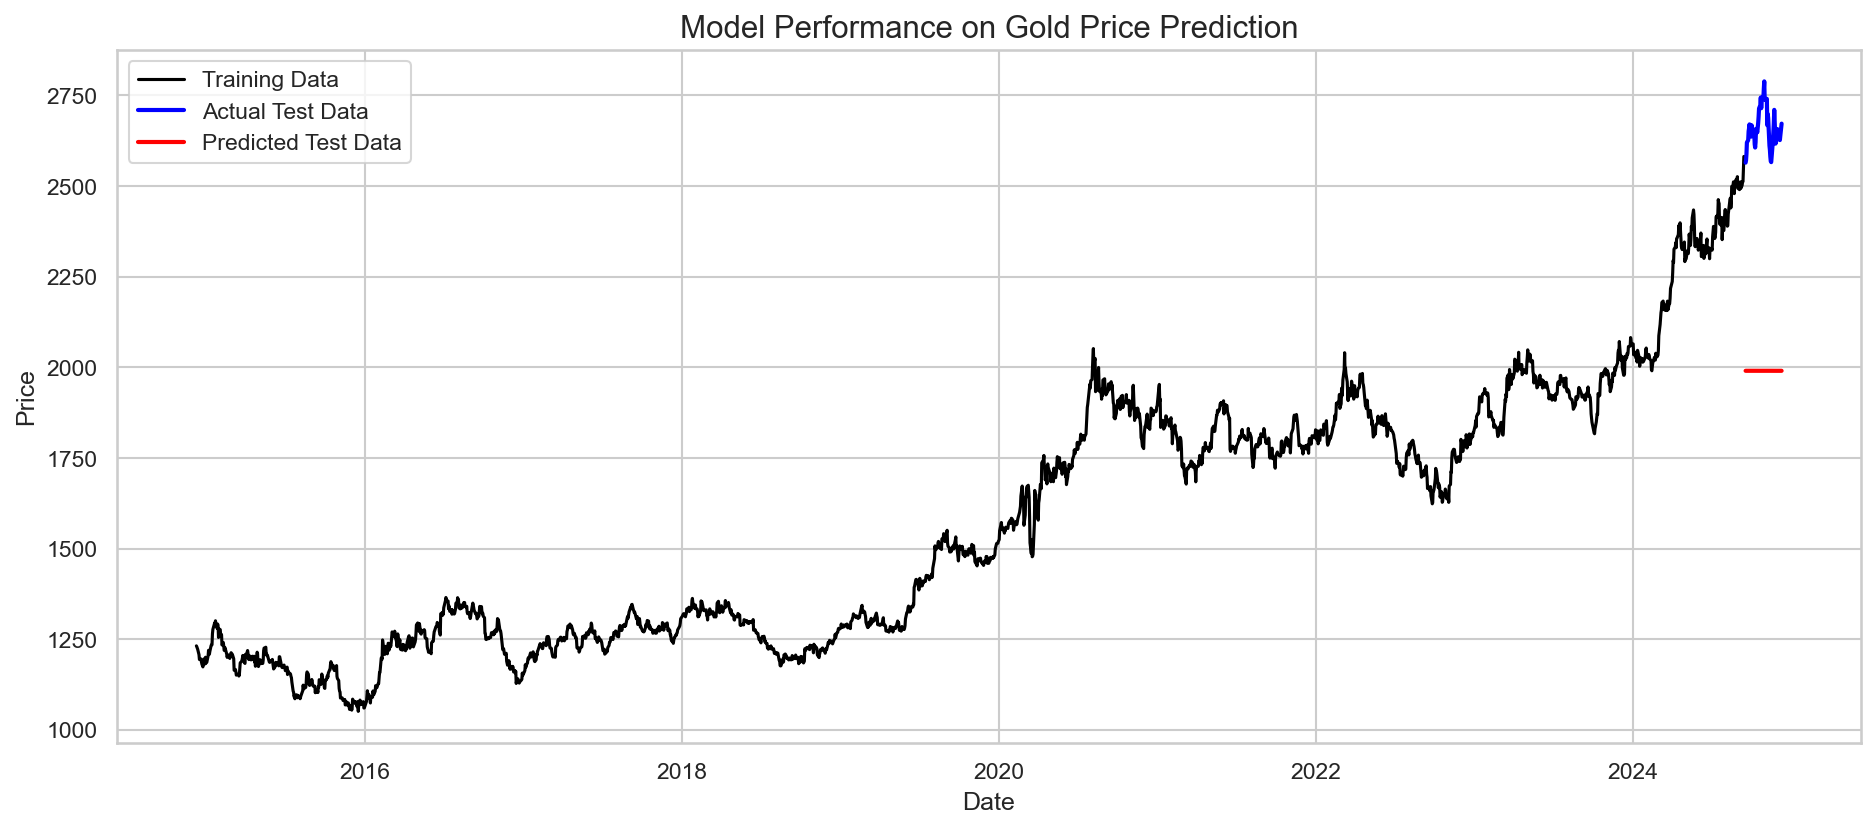

In [44]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.show()

# Data check 

In [46]:
# data from yfinance
df

,Date,Price,High,Low,Open
0,2014-12-09,1231.500000,1238.0,1202.0,1202.0
1,2014-12-10,1228.900024,1234.5999755859375,1226.5999755859375,1231.199951171875
2,2014-12-11,1225.099976,1231.199951171875,1216.199951171875,1226.5999755859375
3,2014-12-12,1222.000000,1227.800048828125,1216.199951171875,1227.800048828125
4,2014-12-15,1207.199951,1223.0999755859375,1198.4000244140625,1223.0999755859375
...,...,...,...,...,...
2510,2024-12-03,2644.699951,2654.699951171875,2636.0,2639.0
2511,2024-12-04,2653.800049,2658.300048828125,2637.0,2639.199951171875
2512,2024-12-05,2626.600098,2655.0,2625.699951171875,2652.39990234375
2513,2024-12-06,2638.600098,2643.10009765625,2617.5,2620.199951171875


In [47]:
# data from Kaggle 
df_k

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [48]:
# Ensure 'Date' columns are in datetime format for both dataframes
df['Date'] = pd.to_datetime(df['Date'])
df_k['Date'] = pd.to_datetime(df_k['Date'])

# Merge df and df1 on 'Date'
merged_df = pd.merge(df_k, df[['Date', 'Price']], on='Date', how='left')

In [49]:
df_k

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-12-30,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,2022-12-29,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,2022-12-28,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,2022-12-27,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,2022-12-26,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,2013-01-08,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,2013-01-07,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,2013-01-04,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,2013-01-03,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [50]:
merged_df.dropna(inplace=True)

In [51]:
merged_df

,Date,Price_x,Open,High,Low,Vol.,Change %,Price_y
0,2022-12-30,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%,1819.699951
1,2022-12-29,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%,1819.500000
2,2022-12-28,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%,1807.900024
3,2022-12-27,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%,1814.800049
5,2022-12-23,"1,804.20","1,801.00","1,812.20","1,798.90",105.46K,0.50%,1795.900024
...,...,...,...,...,...,...,...,...
2078,2014-12-15,"1,207.70","1,222.00","1,225.00","1,191.30",152.38K,-1.21%,1207.199951
2079,2014-12-12,"1,222.50","1,227.90","1,228.90","1,214.80",121.18K,-0.25%,1222.000000
2080,2014-12-11,"1,225.60","1,226.20","1,233.40","1,216.40",143.67K,-0.31%,1225.099976
2081,2014-12-10,"1,229.40","1,231.20","1,238.90","1,225.20",143.32K,-0.21%,1228.900024


In [52]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2027 entries, 0 to 2082
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2027 non-null   datetime64[ns]
 1   Price_x   2027 non-null   object        
 2   Open      2027 non-null   object        
 3   High      2027 non-null   object        
 4   Low       2027 non-null   object        
 5   Vol.      2027 non-null   object        
 6   Change %  2027 non-null   object        
 7   Price_y   2027 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 142.5+ KB


In [53]:
merged_df['Price_x'] = merged_df['Price_x'].replace({',': ''}, regex=True).astype(float)

In [54]:
merged_df

,Date,Price_x,Open,High,Low,Vol.,Change %,Price_y
0,2022-12-30,1826.2,"1,821.80","1,832.40","1,819.80",107.50K,0.01%,1819.699951
1,2022-12-29,1826.0,"1,812.30","1,827.30","1,811.20",105.99K,0.56%,1819.500000
2,2022-12-28,1815.8,"1,822.40","1,822.80","1,804.20",118.08K,-0.40%,1807.900024
3,2022-12-27,1823.1,"1,808.20","1,841.90","1,808.00",159.62K,0.74%,1814.800049
5,2022-12-23,1804.2,"1,801.00","1,812.20","1,798.90",105.46K,0.50%,1795.900024
...,...,...,...,...,...,...,...,...
2078,2014-12-15,1207.7,"1,222.00","1,225.00","1,191.30",152.38K,-1.21%,1207.199951
2079,2014-12-12,1222.5,"1,227.90","1,228.90","1,214.80",121.18K,-0.25%,1222.000000
2080,2014-12-11,1225.6,"1,226.20","1,233.40","1,216.40",143.67K,-0.31%,1225.099976
2081,2014-12-10,1229.4,"1,231.20","1,238.90","1,225.20",143.32K,-0.21%,1228.900024


In [55]:
merged_df['diff'] = merged_df['Price_x'] - merged_df['Price_y']

In [56]:
merged_df

,Date,Price_x,Open,High,Low,Vol.,Change %,Price_y,diff
0,2022-12-30,1826.2,"1,821.80","1,832.40","1,819.80",107.50K,0.01%,1819.699951,6.500049
1,2022-12-29,1826.0,"1,812.30","1,827.30","1,811.20",105.99K,0.56%,1819.500000,6.500000
2,2022-12-28,1815.8,"1,822.40","1,822.80","1,804.20",118.08K,-0.40%,1807.900024,7.899976
3,2022-12-27,1823.1,"1,808.20","1,841.90","1,808.00",159.62K,0.74%,1814.800049,8.299951
5,2022-12-23,1804.2,"1,801.00","1,812.20","1,798.90",105.46K,0.50%,1795.900024,8.299976
...,...,...,...,...,...,...,...,...,...
2078,2014-12-15,1207.7,"1,222.00","1,225.00","1,191.30",152.38K,-1.21%,1207.199951,0.500049
2079,2014-12-12,1222.5,"1,227.90","1,228.90","1,214.80",121.18K,-0.25%,1222.000000,0.500000
2080,2014-12-11,1225.6,"1,226.20","1,233.40","1,216.40",143.67K,-0.31%,1225.099976,0.500024
2081,2014-12-10,1229.4,"1,231.20","1,238.90","1,225.20",143.32K,-0.21%,1228.900024,0.499976


In [57]:
merged_df['diff'].max()

21.200000000000045